In this notebook we'll learn how to remove noise from pseudo-tracking data generated to ressemble that produced by the CLAS12 drift chambers. This comes in the form of a 2D array where the columns represent the wires in each of the superlayers, represented as rows.

To run individual cells you can click on the arrow at the top-right of the cell. You can run all cells if you go to Runtime -> Run all or Restart and run all.

The cell below imports all the librairies that we need

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import math
import seaborn as sns
import random
import math
import time

Next we define a bunch of helper functions to plot, generate, noisify and remove a superlayer row from our data. 

genDC generates our data and takes as arguments the number of superlayers and wires per layer in the DC, and the maximal amount of tracks per event. If this maxTracks value is greater than 1, then a random number of tracks between 1 and maxTracks are generated per event. To generate the tracks, a random number is generated for the wire number in the first and last superlayers as the start and end point of the tracks.

noiseDC adds a random amount of noise to our data which is passed as the first argument. We also need to specify the number of wires and number of superlayers, as well as the maximum amount of noise, which comes in the form of a hit at random wire and superlayer.

removeSL takes our generated data and removes the specified superlayer row (byeSL).

In [2]:
def plotDC(dcIm):
    y_axis_labelsDC = []
    for SL in range(dcIm.shape[0]):
        y_axis_labelsDC.append(str(SL))
    fig=plt.figure(figsize = (10,10))
    axDC=sns.heatmap(dcIm,cmap='Blues',yticklabels=y_axis_labelsDC, vmin=0, vmax=1)
    axDC.invert_yaxis()
    axDC.set(xlabel="Wire")
    axDC.set(ylabel="Superlayer")
    plt.show()

In [3]:
 def genDC(nbSL,nbWires,maxTracks):
    dcGen=np.zeros((nbSL,nbWires))
    nbTracks=1
    if(maxTracks>1):
        nbTracks=random.randint(1,maxTracks)
    for i in range(nbTracks):
        wireFirst=random.randint(0,nbWires-1)
        wireLast=random.randint(0,nbWires-1)
        dif = wireLast-wireFirst
        dcGen[0,wireFirst]=1
        dcGen[nbSL-1,wireLast]=1
        for SL in range(1,nbSL-1):
            wire=wireFirst+math.ceil((dif*(SL/nbSL)*(SL/nbSL)))
            if wire>(nbWires-1):
                wire=nbWires-1
            elif wire<0:
                wire=0
            dcGen[SL,wire]=1
    return dcGen

In [4]:
def noiseDC(dcNS,nbSL,nbWires,maxNoise):
    nbNoise=10
    if (maxNoise>10):
        nbNoise=random.randint(10,maxNoise)
    for noiseIt in range(nbNoise):
        randomSL=random.randint(0,nbSL-1)
        randomWire=random.randint(0,nbWires-1)
        dcNS[randomSL,randomWire]=1
    return dcNS

In [5]:
def removeSL(dcRM,byeSL,nbWires):
    dcRM[byeSL]=np.zeros((1,nbWires))
    return dcRM

cleanDC will help clean up the output of the classifier. This output is given as a probability that there was a non-noisy hit in a given wire. We can then apply a lower limit on this probability to clean up our images.

In [6]:
def cleanDC(dcCL,nbSL,nbWires,mseTh):
    for SL in range(nbSL):
        for wire in range(nbWires):
            if dcCL[SL,wire]>mseTh:
                dcCL[SL,wire]=1
            else:
                dcCL[SL,wire]=0
    return dcCL

Next we specify some parameters for the data that we then generate. First nbGen specifies how many training and testing events we want to generate, nbSL and nbWires specify the number of superlayers and wires in our toy drift chamber, maxNoise specifies the maximal amount of noisy hits we want to add, and maxNbTracks specifies the maximal number of tracks per event. Once we generate the data we then remove superlayers one superlayer hit and add noise.

We can then plot at random one event from the generated data, before separating it into training and testing samples.

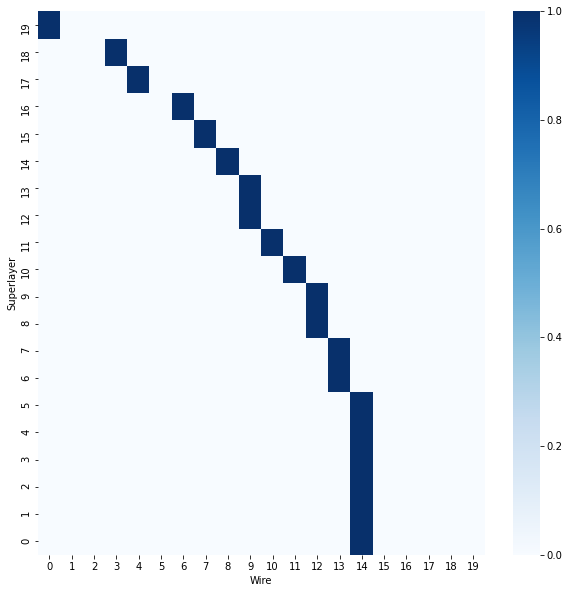

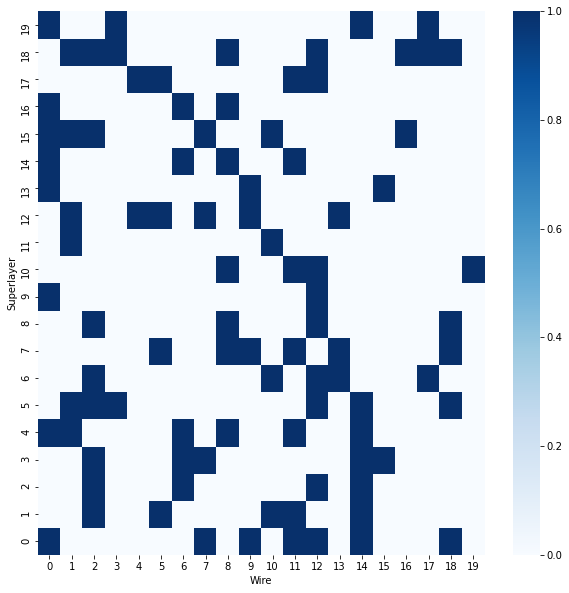

In [7]:
nbGen=20000
nbSL=20
nbWires=20
maxNoise=(nbSL*nbWires)/4 #hardcoded 10 minimum
maxNbTracks=1 #hardcoded 1 minimum
dc=np.zeros((nbGen,nbSL,nbWires))
orgDC=np.zeros((nbGen,nbSL,nbWires))
#seed pseudo random number generator
random.seed(time.time())
for genIt in range(nbGen):
    #Generate Data
    gen=genDC(nbSL,nbWires,maxNbTracks)
    orgDC[genIt]=gen
    
    #Remove layer
    removedSL=random.randint(0,nbSL-1)
    dcMod=removeSL(gen.copy(),removedSL,nbWires)
    
    #Noise
    dc[genIt]=noiseDC(dcMod,nbSL,nbWires,maxNoise)
        
        
examplePlotNB=random.randint(0,nbGen)
plotDC(orgDC[examplePlotNB])
plotDC(dc[examplePlotNB])

X_train, X_test, y_train, y_test = train_test_split(dc, orgDC, test_size=0.3,random_state=56)

Next we define a helper function to create the desired network architecture. Here we're using an autoencoder, where the input is the noisy data and the output is the original data. An autoencoder then encodes the initial 2D array into a layer of N neurons (specified by the code_size argument) before decoding this to the noiseless image.

The autoencoder architecture suggested here is very basic, and you can play around with this to try and improve its performance. We also use the Mean Squared Error loss function (mse) but you can also try and see what happens with other loss functions such as the Mean Absolute Error (mae).

In [8]:
def define_autoencoder(img_shape,code_size):
    prodIm=np.prod(img_shape)
    x=Input(img_shape,name='encoder_0')
    h=x
    h=Flatten()(h)
    h=Dense(prodIm,name='encoder_1', activation='relu')(h)
    h=Dense(code_size,name='encoder_3', activation='relu')(h)
    h=Dense(prodIm,name='decoder_2', activation='linear')(h) #works best when this is linear
    h=Reshape(img_shape)(h)
    autoencoder = Model(inputs=x,outputs=h)
    autoencoder.compile(optimizer='adamax', loss='mse')
    return autoencoder

Next we train the autoencoder on our generated data, and evaluate it at each epoch on the testing data. A clear sign of overfitting, where the network starts learning by heart the trainign data, is when the network starts to perform less well on the testing data than on the training data. We therefore plot the training and validation loss as a function of the epoch to check that the validation loss doesn't start to increase which would be a sing of overfitting.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_0 (InputLayer)       [(None, 20, 20)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
encoder_1 (Dense)            (None, 400)               160400    
_________________________________________________________________
encoder_3 (Dense)            (None, 1000)              401000    
_________________________________________________________________
decoder_2 (Dense)            (None, 400)               400400    
_________________________________________________________________
reshape (Reshape)            (None, 20, 20)            0         
Total params: 961,800
Trainable params: 961,800
Non-trainable params: 0
_______________________________________________________

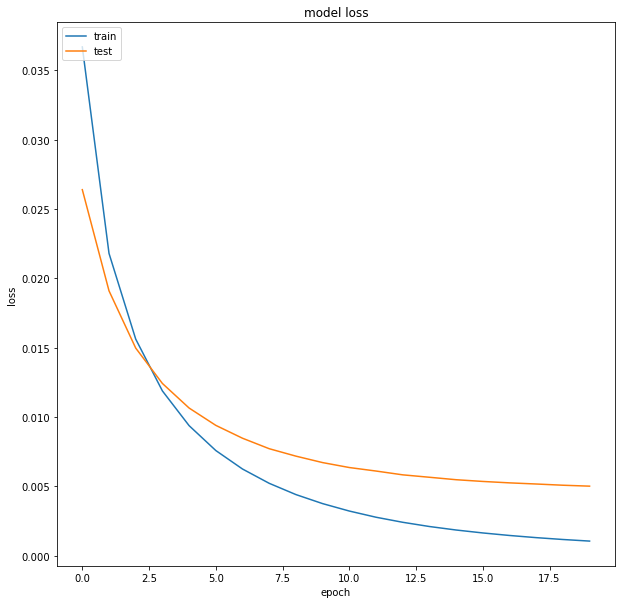

In [9]:
code_size=1000 #play about with this
autoencoder=define_autoencoder(X_train.shape[1:],code_size)
autoencoder.summary()

history = autoencoder.fit(x=X_train, y=y_train, epochs=20,validation_data=(X_test, y_test))

fig = plt.figure(figsize = (10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



Finally we use the trained network to predict on the testing data, so that we can then plot this and check what it looks like.

The autoencoder output is given as a probability that there was a non-noisy hit in a given wire/superlayer. We can then apply a lower limit on this probability to clean up our images using the cleanDC function.

In [10]:
start = time.time()
DC_pred = autoencoder.predict(X_test)
end = time.time()
dif=format(end-start, ".3f")

print("It took "+dif+"s to remove noise from "+str(DC_pred.shape[0])+" images.")

DC_pred_clean=np.zeros((X_test.shape[0],nbSL,nbWires))
for pred in range(X_test.shape[0]):
    DC_pred_clean[pred]=cleanDC(DC_pred[pred].copy(),nbSL,nbWires,0.4)

It took 0.564s to remove noise from 6000 images.


Here we plot an example taken at random from the original and noisy data.

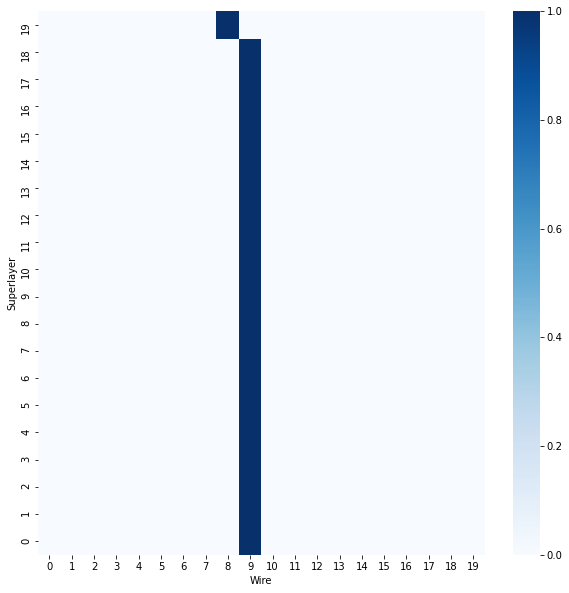

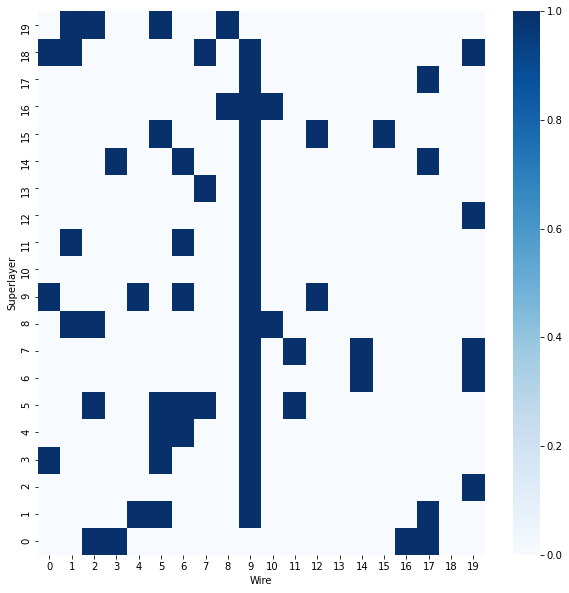

In [11]:
examplePlotNB=random.randint(0,X_test.shape[0])
plotDC(y_test[examplePlotNB])
plotDC(X_test[examplePlotNB])

We then plot the autoencoder output, and the output after having applied a lower limit.

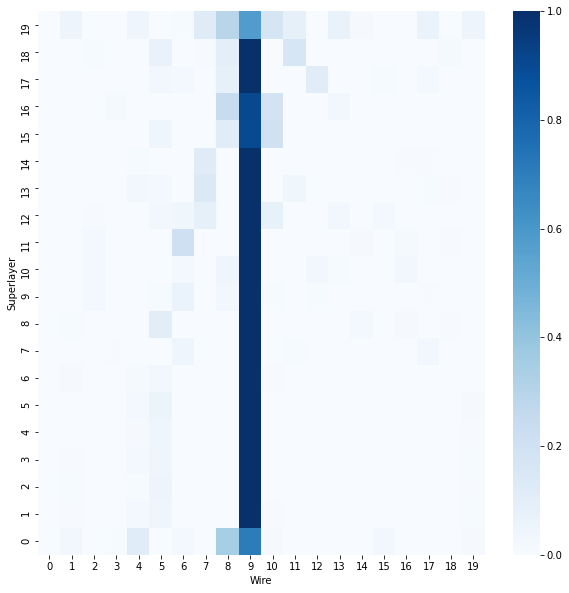

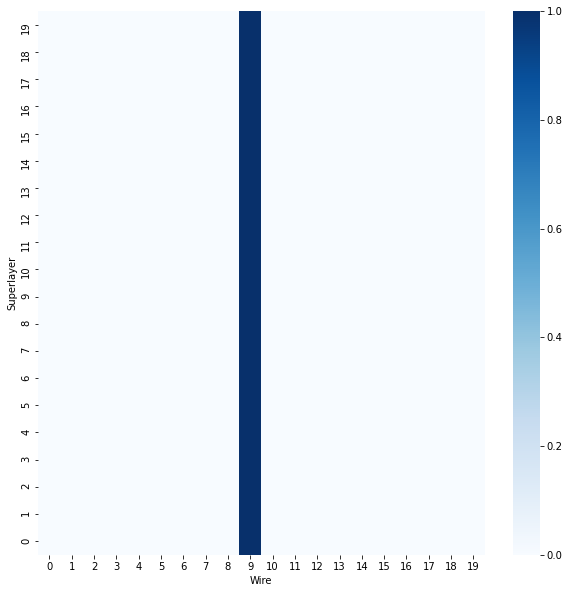

In [12]:
plotDC(DC_pred[examplePlotNB])
plotDC(DC_pred_clean[examplePlotNB])